In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc


In [31]:
df = pd.read_csv("Global_Pollution_Analysis.csv")
df.columns = df.columns.str.strip()

df.head()


,Country,Year,Air_Pollution_Index,Water_Pollution_Index,Soil_Pollution_Index,Industrial_Waste (in tons),Energy_Recovered (in GWh),CO2_Emissions (in MT),Renewable_Energy (%),Plastic_Waste_Produced (in tons),Energy_Consumption_Per_Capita (in MWh),Population (in millions),GDP_Per_Capita (in USD)
0,Hungary,2005,272.70,124.27,51.95,94802.83,158.14,5.30,41.11,37078.88,12.56,42.22,20972.96
1,Singapore,2001,86.72,60.34,117.22,56283.92,498.04,6.34,36.44,33128.20,5.23,137.25,34850.41
2,Romania,2016,91.59,83.36,121.72,56256.02,489.51,49.69,9.38,18803.46,13.15,124.47,57773.15
3,Cook Islands,2018,280.61,67.16,93.58,74864.73,145.18,8.91,18.97,9182.27,0.78,67.80,21837.51
4,Djibouti,2008,179.16,127.53,121.55,76862.06,40.38,14.93,34.00,39235.12,12.84,186.52,41379.37


In [32]:
df.info()
df.describe()


<class 'pandas.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Country                                 200 non-null    str    
 1   Year                                    200 non-null    int64  
 2   Air_Pollution_Index                     200 non-null    float64
 3   Water_Pollution_Index                   200 non-null    float64
 4   Soil_Pollution_Index                    200 non-null    float64
 5   Industrial_Waste (in tons)              200 non-null    float64
 6   Energy_Recovered (in GWh)               200 non-null    float64
 7   CO2_Emissions (in MT)                   200 non-null    float64
 8   Renewable_Energy (%)                    200 non-null    float64
 9   Plastic_Waste_Produced (in tons)        200 non-null    float64
 10  Energy_Consumption_Per_Capita (in MWh)  200 non-null    float64
 11  Popu

,Year,Air_Pollution_Index,Water_Pollution_Index,Soil_Pollution_Index,Industrial_Waste (in tons),Energy_Recovered (in GWh),CO2_Emissions (in MT),Renewable_Energy (%),Plastic_Waste_Produced (in tons),Energy_Consumption_Per_Capita (in MWh),Population (in millions),GDP_Per_Capita (in USD)
count,200.000000,200.00000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000
mean,2009.335000,180.62695,115.068100,76.488550,52891.68150,260.448700,24.878100,27.799700,24492.893550,9.43575,104.271300,35307.602400
std,5.765325,67.07331,47.580911,39.692727,27224.49169,147.141923,14.470892,12.361879,14421.356002,5.57567,56.906574,19481.714455
min,2000.000000,50.30000,31.130000,11.150000,1019.37000,11.730000,1.920000,5.040000,542.950000,0.53000,2.320000,1298.700000
25%,2004.000000,134.97250,74.550000,40.895000,31201.97250,118.355000,11.220000,17.700000,12843.882500,4.58250,60.960000,19525.020000
50%,2010.000000,183.38500,112.305000,78.600000,55299.15000,273.140000,25.355000,29.170000,24121.540000,9.22500,104.965000,35043.325000
75%,2014.000000,237.42500,157.477500,109.212500,74805.82500,384.957500,38.550000,37.072500,36516.232500,13.99750,150.930000,51629.547500
max,2019.000000,297.95000,199.320000,149.230000,99739.36000,499.980000,49.690000,49.560000,49852.280000,19.98000,198.820000,69143.140000


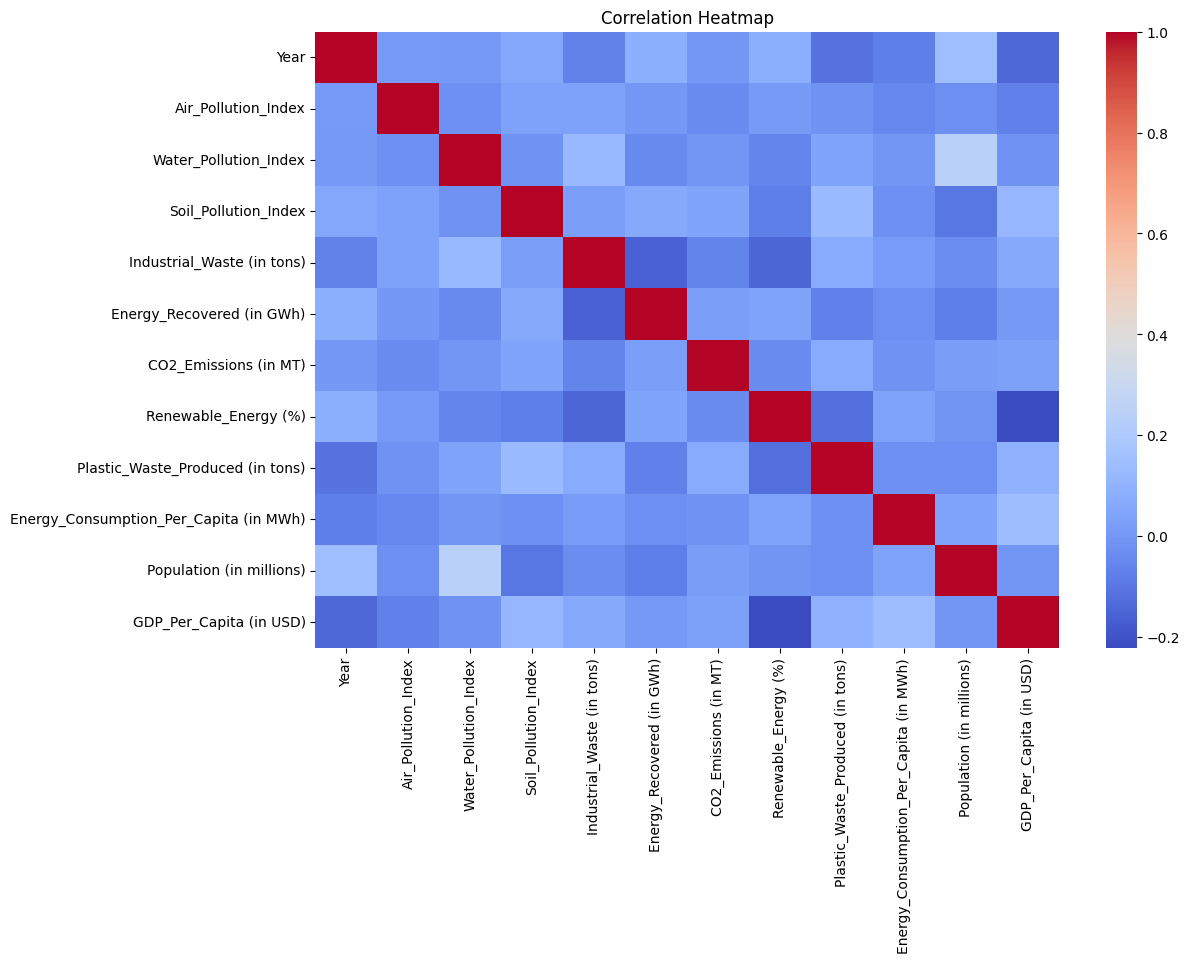

In [33]:
plt.figure(figsize=(12,8))
sns.heatmap(df.select_dtypes(include=['number']).corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()


In [34]:
median_pollution = df['Air_Pollution_Index'].median()

df['Pollution_Severity'] = df['Air_Pollution_Index'].apply(
    lambda x: 1 if x > median_pollution else 0
)


In [35]:
df_encoded = pd.get_dummies(df, drop_first=True)


In [36]:
y_reg = df_encoded['Energy_Recovered (in GWh)']
X_reg = df_encoded.drop(['Energy_Recovered (in GWh)', 'Pollution_Severity'], axis=1)


In [37]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)


In [38]:
scaler_reg = StandardScaler()

X_train_reg = scaler_reg.fit_transform(X_train_reg)
X_test_reg = scaler_reg.transform(X_test_reg)


In [39]:
lr_model = LinearRegression()
lr_model.fit(X_train_reg, y_train_reg)

y_pred_lr = lr_model.predict(X_test_reg)

mse_lr = mean_squared_error(y_test_reg, y_pred_lr)
mae_lr = mean_absolute_error(y_test_reg, y_pred_lr)
r2_lr = r2_score(y_test_reg, y_pred_lr)

print("Linear Regression Results")
print("MSE:", mse_lr)
print("MAE:", mae_lr)
print("R²:", r2_lr)


Linear Regression Results
MSE: 61003.02571587616
MAE: 189.92439487046127
R²: -1.5226378682196158


In [40]:
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)

y_pred_rf = rf_reg.predict(X_test_reg)

mse_rf = mean_squared_error(y_test_reg, y_pred_rf)
mae_rf = mean_absolute_error(y_test_reg, y_pred_rf)
r2_rf = r2_score(y_test_reg, y_pred_rf)

print("\nRandom Forest Regression Results")
print("MSE:", mse_rf)
print("MAE:", mae_rf)
print("R²:", r2_rf)



Random Forest Regression Results
MSE: 27272.130266563
MAE: 143.43764000000002
R²: -0.12777534802745705


In [41]:
y_clf = df_encoded['Pollution_Severity']
X_clf = df_encoded.drop(['Pollution_Severity', 'Energy_Recovered (in GWh)'], axis=1)


In [42]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)


In [43]:
scaler_clf = StandardScaler()

X_train_clf = scaler_clf.fit_transform(X_train_clf)
X_test_clf = scaler_clf.transform(X_test_clf)


In [44]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_clf, y_train_clf)

y_pred_log = log_model.predict(X_test_clf)
y_prob_log = log_model.predict_proba(X_test_clf)[:,1]

accuracy_log = accuracy_score(y_test_clf, y_pred_log)
precision_log = precision_score(y_test_clf, y_pred_log)
recall_log = recall_score(y_test_clf, y_pred_log)
f1_log = f1_score(y_test_clf, y_pred_log)

fpr, tpr, _ = roc_curve(y_test_clf, y_prob_log)
roc_auc_log = auc(fpr, tpr)

print("\nLogistic Regression Results")
print("Accuracy:", accuracy_log)
print("Precision:", precision_log)
print("Recall:", recall_log)
print("F1 Score:", f1_log)
print("ROC-AUC:", roc_auc_log)



Logistic Regression Results
Accuracy: 0.75
Precision: 0.6086956521739131
Recall: 0.9333333333333333
F1 Score: 0.7368421052631579
ROC-AUC: 0.9413333333333334


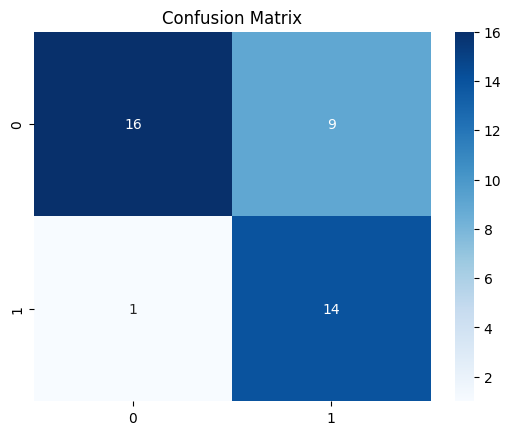

In [45]:
cm = confusion_matrix(y_test_clf, y_pred_log)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


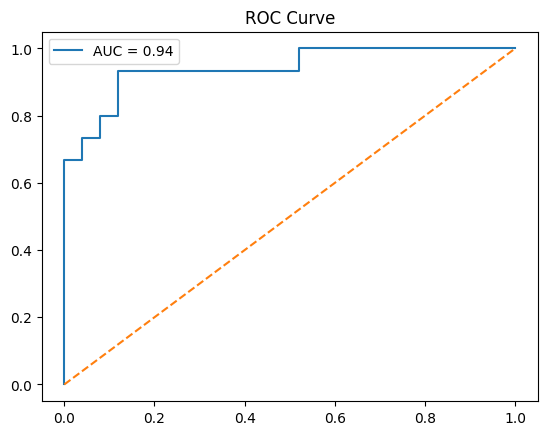

In [46]:
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_log:.2f}")
plt.plot([0,1], [0,1], '--')
plt.legend()
plt.title("ROC Curve")
plt.show()


In [47]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_clf, y_train_clf)

y_pred_rf_clf = rf_clf.predict(X_test_clf)

accuracy_rf = accuracy_score(y_test_clf, y_pred_rf_clf)

print("\nRandom Forest Classification Accuracy:", accuracy_rf)



Random Forest Classification Accuracy: 1.0


In [48]:
print("\nModel Comparison Summary")

print("\nRegression:")
print("Linear Regression R²:", r2_lr)
print("Random Forest Regression R²:", r2_rf)

print("\nClassification:")
print("Logistic Regression ROC-AUC:", roc_auc_log)
print("Random Forest Accuracy:", accuracy_rf)



Model Comparison Summary

Regression:
Linear Regression R²: -1.5226378682196158
Random Forest Regression R²: -0.12777534802745705

Classification:
Logistic Regression ROC-AUC: 0.9413333333333334
Random Forest Accuracy: 1.0
